In [92]:
import os
import cv2 as cv
import six.moves.cPickle as pickle
import numpy as np
import math

train = []
test = []
train_cls = []
test_cls = []
dic = []
dic_ = []
dic_cls = []
IMG_PATH = "./merge/characters/"
dn=0

tmp = os.listdir(IMG_PATH)
# 学習画像の選択（>=100）
for d in tmp:
    if not d.startswith("U+"):
        continue
    tmp2 = os.listdir(IMG_PATH+d)
    if len(tmp2) >= 100:
        dic.append(d)
        
dic_cls = range(len(dic))
dic_cls = map(lambda x: x+1, dic_cls)
dic = dict(zip(dic,dic_cls))
tmp =map(lambda x:unichr(int(x.replace("U+",""),16)),dic)
dic2 = dict(zip(dic_cls,tmp))

tmp = os.listdir(IMG_PATH)
for d in tmp:
    if not d.startswith("U+"):
        continue
    if(not dic.has_key(d)):
        continue
    tmp2 = os.listdir(IMG_PATH+d)
    # 85% train 15% test
    tmp_data = []
    tmp_cls = []
    for f in tmp2:
        image = cv.imread(IMG_PATH+d+"/"+f)
        image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        image = cv.resize(image, (32, 32))
        image = image/255.0
        tmp_data.append(image)
        tmp_cls.append(dic[d])
    if len(tmp_data)==1:
        train.extend(tmp_data)
        test.extend(tmp_data)
        train_cls.extend(tmp_cls)
        test_cls.extend(tmp_cls)
    else:
        train.extend(tmp_data[1:int(math.ceil(len(tmp_data)*0.85))])
        test.extend(tmp_data[int(math.ceil(len(tmp_data)*0.85)):len(tmp_data)])
        train_cls.extend(tmp_cls[1:int(math.ceil(len(tmp_cls)*0.85))])
        test_cls.extend(tmp_cls[int(math.ceil(len(tmp_cls)*0.85)):len(tmp_cls)])    

train = np.array(train, np.float32)
test = np.array(test, np.float32)
train_cls = np.array(train_cls, np.int32)
test_cls = np.array(test_cls, np.int32)
pickle.dump((train,train_cls,test,test_cls), open("dataset_mono20161121.pkl", 'wb'), -1)

In [99]:
%matplotlib inline
from __future__ import division, print_function
from keras import backend as K
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D,MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import os
np.set_printoptions(suppress=True) #小数点表示とする
np.set_printoptions(precision=3) #小数点第三位までとする

In [100]:
train,train_cls,test,test_cls = pickle.load(open("dataset_mono20161121.pkl","rb"))

In [76]:
train.shape

(60546, 32, 32)

In [77]:
test.shape

(10640, 32, 32)

In [78]:
len(train)/(len(train)+len(test))

0.8505324080577642

In [79]:
len(test)/(len(train)+len(test))

0.14946759194223583

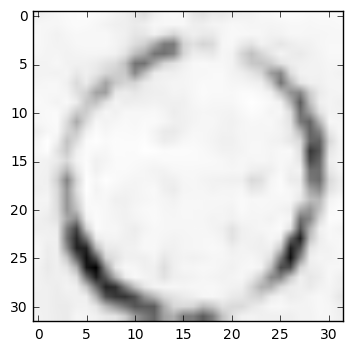

In [80]:
import matplotlib.pyplot as plt

plt.imshow(train[1],cmap='Greys_r')

In [101]:
x_train = train
y_train = to_categorical(train_cls)
x_test = test
y_test = to_categorical(test_cls)

In [82]:
model = Sequential()
model.add(Convolution1D(96, 3, border_mode='same', input_shape=x_train[1].shape))
model.add(Activation('relu'))
model.add(Convolution1D(32, 2))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Convolution1D(64, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution1D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(dic)+1))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [83]:
model.fit(x_train, y_train, batch_size=128, nb_epoch=200, verbose=1)

Epoch 1/200
60546/60546 [==============================] - 32s - loss: 4.1787 - acc: 0.1007    
Epoch 2/200
60546/60546 [==============================] - 36s - loss: 2.9442 - acc: 0.3049    
Epoch 3/200
60546/60546 [==============================] - 34s - loss: 2.3827 - acc: 0.4157    
Epoch 4/200
60546/60546 [==============================] - 34s - loss: 2.0376 - acc: 0.4875    
Epoch 5/200
60546/60546 [==============================] - 38s - loss: 1.8146 - acc: 0.5358    
Epoch 6/200
60546/60546 [==============================] - 35s - loss: 1.6541 - acc: 0.5749    
Epoch 7/200
60546/60546 [==============================] - 35s - loss: 1.5175 - acc: 0.6034    
Epoch 8/200
60546/60546 [==============================] - 35s - loss: 1.4182 - acc: 0.6259    
Epoch 9/200
60546/60546 [==============================] - 36s - loss: 1.3453 - acc: 0.6462    
Epoch 10/200
60546/60546 [==============================] - 38s - loss: 1.2716 - acc: 0.6628    
Epoch 11/200
60546/60546 [=============

In [84]:
model.save("model20161121.h5")

In [102]:
from keras.models import load_model
model = load_model('./model20161121.h5')

In [103]:
evaluation = model.evaluate(x_test,y_test,verbose=1)

10624/10640 [============================>.] - ETA: 0s

In [104]:
print('Test loss :', evaluation[0])
print('Test accuracy :', evaluation[1])

Test loss : 0.94267200181
Test accuracy : 0.753571428571
